In [61]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [62]:
def ler_video(video_path):
    cap = cv.VideoCapture(video_path)
    if not cap.isOpened():
        print("Erro ao abrir o vídeo.")
        return None
    return cap

In [63]:
def extrator_frames(cap): 
    """Extrai frames de um vídeo capturado pelo OpenCV."""
    frames_selecionados = []
    # extrair 20 frames igualmente espaçados do vídeo
    total_frames = int(cap.get(cv.CAP_PROP_FRAME_COUNT)) #pega o total de frames do vídeo
    frame_indices = np.linspace(0, total_frames - 1, 20, dtype=int) #gera 20 índices igualmente espaçados
    for idx in frame_indices:
        cap.set(cv.CAP_PROP_POS_FRAMES, idx) #define a posição do frame atual
        ret, frame = cap.read() #lê o frame
        if ret:
            frames_selecionados.append(frame)

    return frames_selecionados

analisando frames: [0, 352, 634] de 705 totais


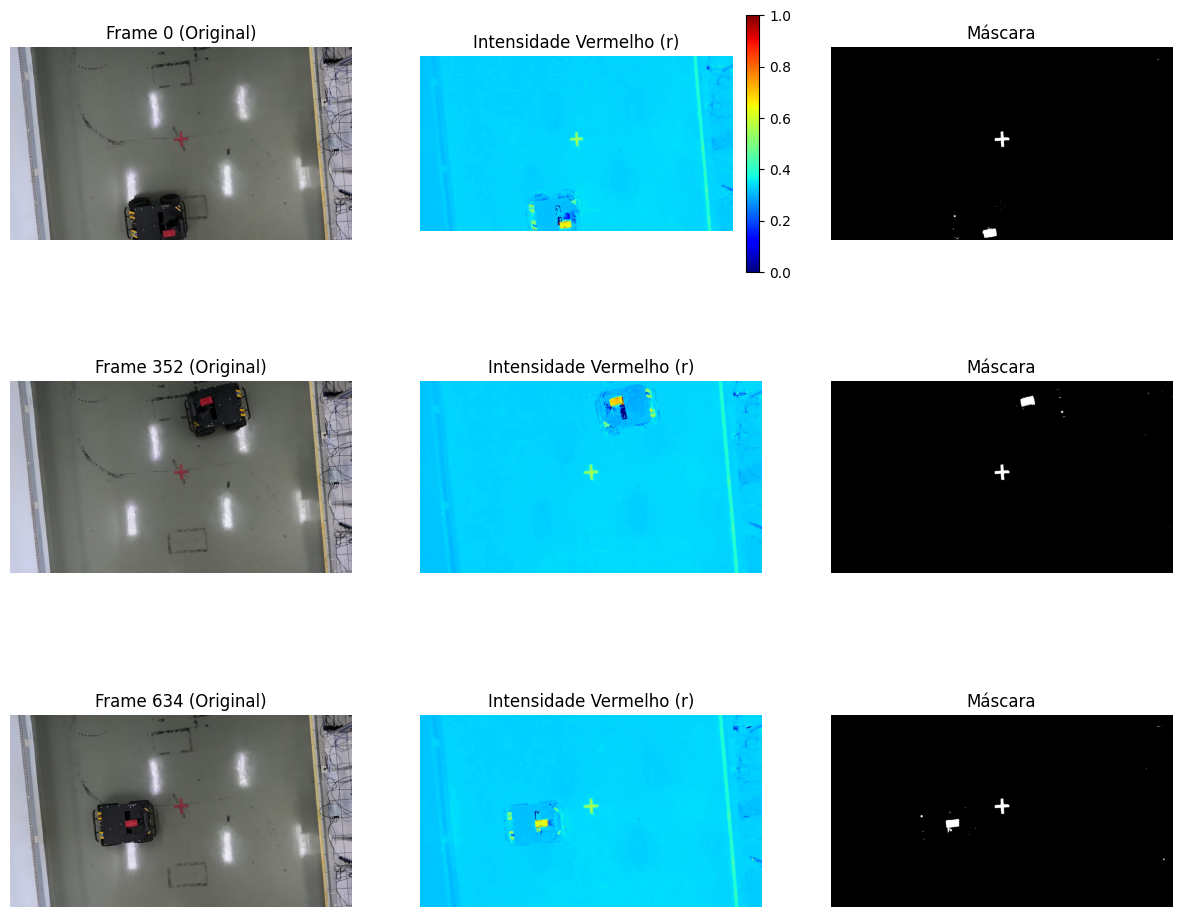

In [64]:
def validar_segmentacao_vermelho(cap):
    total_frames = int(cap.get(cv.CAP_PROP_FRAME_COUNT)) #vê todos os frames pra pegar amostras espalhadas
    
    indices_para_analisar = [0, int(total_frames * 0.5), int(total_frames * 0.9)] #pegando inicio meio e fim
    
    #apenas conguração do plot
    fig, axs = plt.subplots(len(indices_para_analisar), 3, figsize=(15, 12))
    plt.subplots_adjust(hspace=0.3) # Espaço entre as linhas

    print(f"analisando frames: {indices_para_analisar} de {total_frames} totais")

    for i, idx in enumerate(indices_para_analisar):
        #pula direto para o frame que se quer
        cap.set(cv.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        
        if ret:
            frame_rgb = cv.cvtColor(frame, cv.COLOR_BGR2RGB) #converte de BGR para RGB
            img_float = frame_rgb.astype(np.float32) / 255.0
            soma = img_float.sum(axis=2) + 0.000000000000001
            
            r = img_float[:,:,0] / soma
            g = img_float[:,:,1] / soma
            
            #definindo os limiares
            mask = (r > 0.4) & (g < 0.3)
            mask_vis = mask.astype(np.uint8) * 255

            #configuracao da coluna 1 frame original
            axs[i, 0].imshow(frame_rgb)
            axs[i, 0].set_title(f"Frame {idx} (Original)")
            axs[i, 0].axis('off')
            
            #configuracao da coluna 2 mapa de calor para o vermelho
            im = axs[i, 1].imshow(r, cmap='jet', vmin=0, vmax=1)
            axs[i, 1].set_title("Intensidade Vermelho (r)")
            axs[i, 1].axis('off')
            # Adiciona barra de cor apenas na primeira linha para não poluir
            if i == 0: fig.colorbar(im, ax=axs[i, 1], fraction=0.046, pad=0.04)

            #configuracao da coluna 3 máscara binária
            axs[i, 2].imshow(mask_vis, cmap='gray')
            axs[i, 2].set_title("Máscara")
            axs[i, 2].axis('off')
        else:
            print(f"erro ao ler frame {idx}")

    cap.release()
    plt.show()

nome_video = 'video1.mp4'  
cap = cv.VideoCapture(nome_video)
validar_segmentacao_vermelho(cap)


In [65]:
def pixel_para_mundo(u, v): #recebo as coordenadas em pixel e devolvo para milimetros
    #colocando a matriz H que está no pdf. Essa matriz leva de mundo para imagem
    H_pdf = np.array([ 
        [0.9236, 0, 1077.2023],
        [0, -0.9102, 1952.5904],
        [0, 0, 1]
    ])
    
    #precisamos pegar o contrário da informação da matriz H, ou seja, precisamos fazer imagem -> mundo. (u,v) -> (X,Y)
    H_inv = np.linalg.inv(H_pdf) #calculo a inversa da matriz H
    
    ponto_img = np.array([u, v, 1]).reshape(3, 1)   #crio o vetor do ponto na imagem [u, v, 1], o reshape é para garantir que o vetor seja uma matriz coluna
                                                    #util e considerabevl ja que a matriz é 3x3
    # Aplica a transformação: P_mundo = H_inv * P_img
    ponto_mundo = np.dot(H_inv, ponto_img)#multiplico a matriz inversa pela matriz coluna do ponto na imagem
    
    if ponto_mundo[2] != 0: #normalização para o ultimo elemento ser 1
        X = ponto_mundo[0]/ponto_mundo[2]
        Y = ponto_mundo[1]/ponto_mundo[2]
        return float(X), float(Y)
    #return 0.0, 0.0

#resumo:
#1 - pego o pixel u,v
#2 - crio a matriz coluna [u,v,1]
#3 - multiplico pela matriz inversa H_inv
#4 - normalizo dividindo por ponto_mundo[2] que é W em [X,Y,W]

In [66]:
def processar_frame(frame): #passo um frame para ela, ou seja, ela consegue trabalhar imagem por imagem
    """
    Processa um único frame:
    1. Segmenta o vermelho (Cromaticidade)
    2. Encontra o marcador
    3. Calcula centróide e ângulo
    4. Desenha os resultados no frame
    """
    #cromaticidade
    print("Tipo de frame:", type(frame))

    img_float = frame.astype(np.float32) / 255.0 #fazendo a conversão padrão para float
    #soma dos canais 
    soma = img_float.sum(axis=2) + 0.00000000000000001 #eu somei um valor muito pequeno só para evitar divisão por zero caso tenha (0,0,0)
    #r = img_float[:,:,1] / soma
    #r = img_float[:,:,2] / soma
    #r = img_float[:,:,3] / soma
    r = img_float[:,:,2] / soma
    g = img_float[:,:,1] / soma
    
    # definindo os limiares
    mask = (r > 0.4) & (g < 0.3) 
    mask_uint8 = (mask * 255).astype(np.uint8) #convertendo a máscara booleana para uint8 (0 e 255)
    
    
    #ncontrar contornos da máscara
    contours, _ = cv.findContours(mask_uint8, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    dados_robo = None
    frame_out = frame.copy()
    
    if contours:
        #peega o maior contorno
        c = max(contours, key=cv.contourArea)
        
        #filtra ruídos pequenos
        if cv.contourArea(c) > 50: #ajustei a área mínima para 50
            M = cv.moments(c)
            if M['m00'] != 0:
                # Centróide na Imagem
                cx = int(M['m10'] / M['m00'])
                cy = int(M['m01'] / M['m00'])
                
                #Orientação
                mu20 = M['mu20'] / 255.0
                mu02 = M['mu02'] / 255.0
                mu11 = M['mu11'] / 255.0
                
                # autovalores e autovetores da matriz de inércia
                matriz_inercia =  np.array([[mu20, mu11],
                                [mu11, mu02]])
                autovalores, autovetores = np.linalg.eig(matriz_inercia)

                #ângulo de orientação
                theta = np.arctan2(autovetores[1, 0], autovetores[0, 0])
                theta_deg = np.degrees(theta)  #convertendo para graus
                
                #coordenadas do Mundo (usando a função da Etapa 1)
                X_real, Y_real = pixel_para_mundo(cx, cy)
                
                #pacote de dados para retorno
                dados_robo = {
                    'u': cx, 'v': cy,
                    'x_real': X_real, 'y_real': Y_real,
                    'theta': theta_deg
                }

                print(dados_robo)
                
                # --- DESENHOS ---
                #ponto no centro
                cv.circle(frame_out, (cx, cy), 5, (0, 0, 255), -1)
                # Contorno do objeto
                cv.drawContours(frame_out, [c], -1, (0, 255, 0), 2)
                #semi-eixos da elipse
                area = M['m00']/255.0
                a = 2*np.sqrt( autovalores[0] / area) # maior autovalor
                b = 2*np.sqrt(autovalores[1] / area) # menor autovalor
                axes = (int(round(a)), int(round(b)))
                print(f'Semi-eixos da elipse: a={a}, b={b}')

                # centroide
                centroide = (int(round(cx)), int(round(cy)))

                #desenhando a elipse na imagem
                cv.ellipse(frame_out, centroide, axes, theta_deg, 0, 360, (255, 0, 0), 2) #elipse azul

                plt.imshow(cv.cvtColor(frame_out, cv.COLOR_BGR2RGB))
                plt.title('Teste: contorno + centroide + elipse')
                plt.show()

    return dados_robo, frame_out

print("Função 'processar_frame' criada com sucesso.")

Função 'processar_frame' criada com sucesso.


In [67]:
def acumulador_dados(dados, pose):
    """Adiciona os dados deste frame às listas da trajetória."""
    pose["X"].append(dados["x_real"])
    pose["Y"].append(dados["y_real"])
    pose["Theta"].append(dados["theta"])
    pose["u"].append(dados["u"])
    pose["v"].append(dados["v"])

In [68]:
def desenhar_trajetoria(imagem_processada, traj_u, traj_v):
    """Desenha a trajetória no frame."""
    if len(traj_u) > 1:
                # Converte listas de pontos para o formato que o OpenCV gosta
                pts = np.array(list(zip(traj_u, traj_v)), np.int32) # cria uma matriz de pontos
                # Desenha a linha da trajetória (ciano)
                cv.polylines(imagem_processada, [pts], False, (255, 255, 0), 2)

In [69]:
def gerador_graficos(pose, prefixo="video2"):
    """Gera os gráficos finais e salva PNGs."""
    X = pose["X"]
    Y = pose["Y"]
    Theta = pose["Theta"]

    # Gráfico XY
    plt.figure(figsize=(10, 6))
    plt.plot(X, Y, '-o')
    plt.xlabel("X (mm)")
    plt.ylabel("Y (mm)")
    plt.title("Trajetória do Robô")
    plt.grid()
    plt.savefig(f"trajetoria_xy({prefixo}).png")
    plt.close()

    # Gráfico tetha
    plt.figure(figsize=(10, 6))
    plt.plot(Theta, '-o')
    plt.xlabel("Frame")
    plt.ylabel("Ângulo (graus)")
    plt.title("Orientação do Robô ao Longo do Tempo")
    plt.grid()
    plt.savefig(f"angulo_theta({prefixo}).png")
    plt.close()


In [70]:
def gerador_video(frames_processados, nome_video, largura, altura):
    """ Gera um vídeo a partir dos frames processados."""
    fourcc = cv.VideoWriter_fourcc(*"mp4v")
    out = cv.VideoWriter(nome_video, fourcc, 5.0, (largura, altura))

    for frame in frames_processados:
        out.write(frame)

    out.release()

In [71]:
def orquestrador_pose(frames_selecionados):
    """"Processa os frames selecionados para extrair a trajetória do robô."""
   
    pose = {
        "X": [], "Y": [], "Theta": [],
        "u": [], "v": []
    }

    frames_final = []

    # Descobre dimensões no primeiro frame
    _, frame0 = processar_frame(frames_selecionados[0])
    h, w, _ = frame0.shape

    for frame in frames_selecionados:
        dados, frame_proc = processar_frame(frame)

        if dados is not None:
            acumulador_dados(dados, pose)

        # desenha a linha da trajetória
        desenhar_trajetoria(frame_proc, pose["u"], pose["v"])

        frames_final.append(frame_proc)

        # plot do frame em tempo real
        clear_output(wait=True)
        frame_rgb = cv.cvtColor(frame_proc, cv.COLOR_BGR2RGB)
        plt.figure(figsize=(8, 5))
        plt.imshow(frame_rgb)
        plt.title("Rastreamento em Tempo Real")
        plt.axis('off')
        plt.show()

    # Gera vídeo
    gerador_video(frames_final, "trajetoria_robo (video2).mp4", w, h)

    # Gera gráficos
    gerador_graficos(pose)


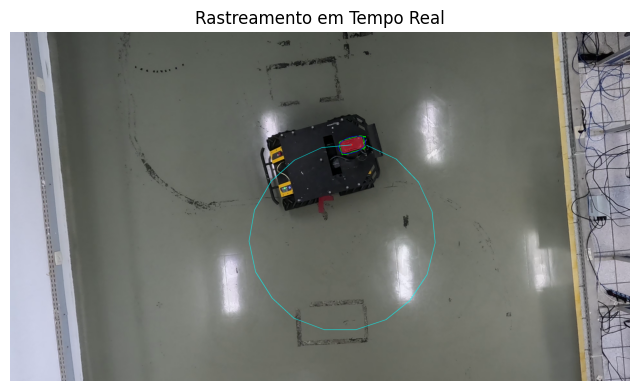

Pipeline concluído.


In [72]:
def pipeline():
    print("Iniciando pipeline...")
    cap = ler_video("video2.mp4")
    # validar_segmentacao_vermelho(cap)
    frames_selecionados = extrator_frames(cap)
    orquestrador_pose(frames_selecionados)  
    print("Pipeline concluído.")
    
    
pipeline()